In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy import signal

In [2]:
# routines
def _shift(pair,shift):
    """shift t1 shift/2 samples to the left and
       shift t2 shift/2 samples to the right,
       if shift is odd move t1 the extra sample
       this process truncates trace length"""
    if shift == 0:
        return pair
    elif shift == 1:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):], t2[:-shift]))
    else:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):-math.floor(shift/2)], t2[:-shift]))

def _rotate(pair,degrees):
    """t1 is x-axis and t2 is y-axis,
       rotates clockwise"""
    ang = np.deg2rad(degrees)
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])
    return np.dot(rot,pair)

def _rotate_and_shift(pair,degrees,shift):
    return _shift(_rotate(pair,degrees), shift)

def _split(pair,degrees,shift):
    return _rotate(_shift(_rotate(pair,degrees), shift),-degrees)

def _unsplit(pair,degrees,shift):
    return _split(pair,degrees+90,shift)
    
def _taper(pair,width,centre=None):
    """Apply Hanning window about c0 sample
       of width number of samples, truncates traces"""
    
    if centre is None:
        centre = math.floor(pair.shape[1]/2)
        
    if width > pair.shape[1]:
        raise Exception('taper width is greater than trace length')
        
    t0 = centre - math.floor(width/2)
    t1 = centre + math.ceil(width/2)
    
    if t0 < 0:
        raise Exception('window starts before trace data')
    elif t1 > pair.shape[1]:
        raise Exception('window ends after trace data')
        
    return np.hanning(width) * pair[:,t0:t1]

def _eigcov(pair):
    return np.sort(np.linalg.eigvals(np.cov(pair,rowvar=True)))
#     return np.sort(np.linalg.eigvals(np.cov(pair)))

def _grideigcov(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
    
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    lam1 = np.zeros(shape)
    lam2 = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            lam2[jj,ii], lam1[jj,ii] = _eigcov(temp3)
    return deg, shift, lam1, lam2

def _xcorr(pair):
    return np.correlate(pair[0,:],pair[1,:])[0]

def _gridxcorr(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
        
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    xc = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            xc[jj,ii] = _xcorr(temp3)
    return deg, shift, xc 

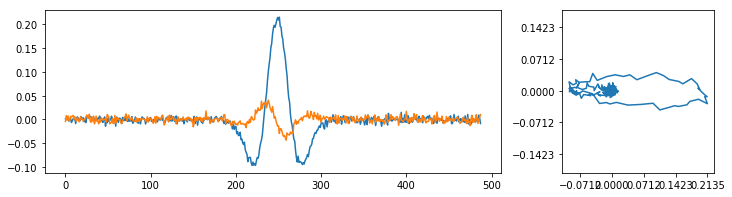

In [3]:
# synthetic data
ricker = signal.ricker(500, 16.0)
pair = np.vstack((ricker,np.zeros(ricker.shape)))
noise = np.random.normal(0,.005,pair.shape)
splitdata = _split(pair+noise,110,12)

def plt_pair(pair):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(12, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(pair.T)
    ax1 = plt.subplot(gs[1])
    ax1.plot(pair[0,:],pair[1,:])
    ticks = np.linspace(-np.abs(pair).max(),np.abs(pair).max(),7)
    ax1.xaxis.set_ticks(ticks)
    ax1.yaxis.set_ticks(ticks)
    plt.axis('equal')
    plt.show()
    
plt_pair(splitdata)

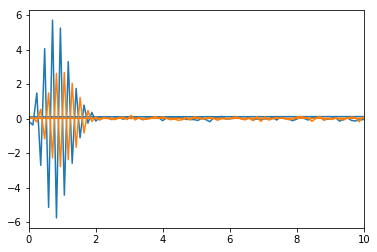

In [4]:
t1 = splitdata[0,:]
sp = np.fft.fft(t1)
freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.xlim(0,10)
plt.show()

In [5]:
np.fft.fft?

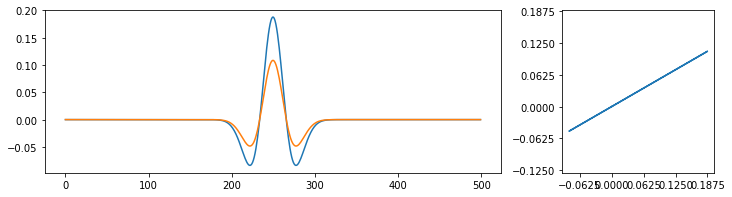

In [6]:
plt_pair(_rotate(pair,30))

In [7]:
f1 = np.fft.fft(pair[0,:])
f2 = np.fft.fft(pair[1,:])

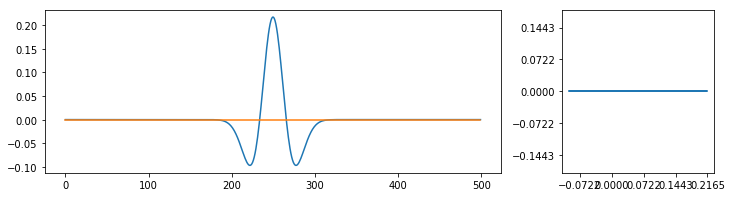

In [8]:
# Forward and reverse Fourier Transform
plt_pair(np.vstack((np.real(np.fft.ifft(f1)),
                            np.real(np.fft.ifft(f2)))))

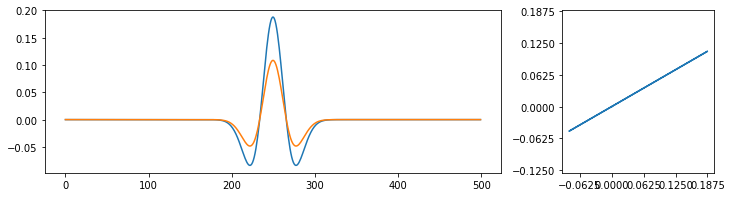

In [9]:
# Rotation in Fourier Domain
rf = _rotate(np.vstack((f1,f2)),30)
data = np.vstack((np.real(np.fft.ifft(rf[0,:])),
                  np.real(np.fft.ifft(rf[1,:]))))
plt_pair(data)

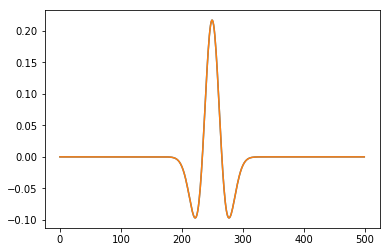

In [10]:
# Shift in the Fourier Domain
# t1 = _taper(splitdata,100)[0,:]
t1 = pair[0,:]
f1 = np.fft.fft(t1)
delta = 1
# shift must be an integer multiple of delta
shift = 0
N = f1.size
P = np.arange(N) * -(2*np.pi * shift)/(delta * N)  
fs = f1 * np.exp(1j*P)
t2 = np.real(np.fft.ifft(fs))
plt.plot(t1)
plt.plot(t2)
# plt.plot(fs.real)
# plt.plot(fs.imag)
# freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
# plt.plot(freq, f1.real, freq, f1.imag)
# plt.xlim(0,4)
# plt.show()


In [11]:
# a = np.array([1,2])
b = np.array([np.pi,np.pi/2])
np.cos(b) + np.sin(b)*1j

array([ -1.00000000e+00 +1.22464680e-16j,   6.12323400e-17 +1.00000000e+00j])

In [12]:
np.cov(t1,t2)

array([[ 0.00200401,  0.00200401],
       [ 0.00200401,  0.00200401]])

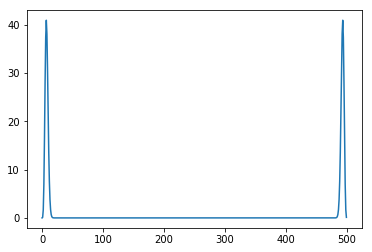

In [13]:
plt.plot(np.abs(f1)**2)

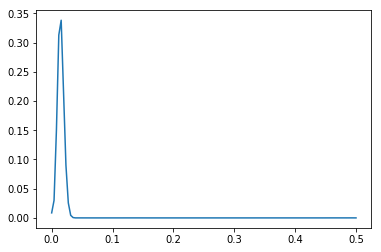

In [14]:
from scipy.signal import welch
f, psd = welch(splitdata[0,:],
               fs=1.,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean
plt.plot(f,psd)

In [15]:
import splitwavepy as sw

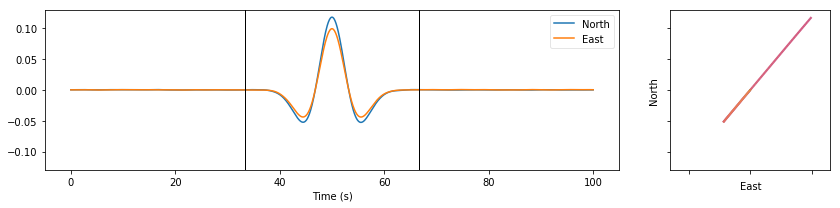

In [16]:
a = sw.SplitWave(pol=40)
a.plot()

In [27]:
# get fourier traces
x = a.x[:-1]
y = a.y[:-1]
x = x - np.mean(x)
y = y - np.mean(y)
fx = np.fft.rfft(x)
fy = np.fft.rfft(y)

In [28]:
# cross correlation (in Fourier domain)
cxy = fx*fy.conj()
cyx = fy*fx.conj()
cxx = fx*fx.conj()
cyy = fy*fy.conj()

In [34]:
# reverse transform cross-correlation
ixy = np.fft.irfft(cxy)
iyx = np.fft.irfft(cyx)
ixx = np.fft.irfft(cxx)
iyy = np.fft.irfft(cyy)

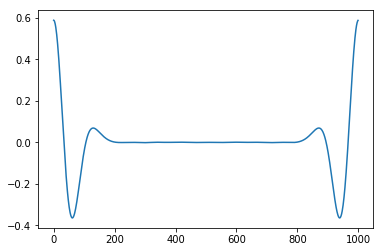

In [46]:
# plt.plot(np.real(ixx))
# plt.plot(np.real(iyy))
plt.plot(ixx)

0.49387445648348138

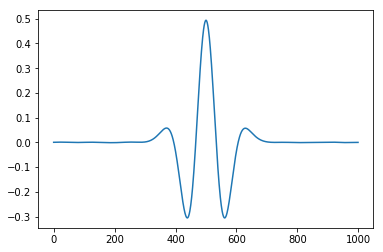

In [40]:
plt.plot(np.correlate(x,y,mode='same'))
np.max(np.correlate(x,y,mode='same'))

In [57]:
# raw correlation coefficient difference between
# fourier method V time domain method
ixy[0] - np.correlate(x,y)

array([ -1.66533454e-16])

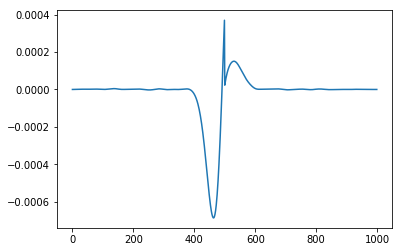

In [72]:
corrxy = np.correlate(x,y,'same')
mid = int(x.size/2)
plt.plot(ixy - np.roll(corrxy,mid))
plt.show()

In [42]:
# Pearson Correlation in time domain
np.correlate(x, y)/(x.size * np.std(x) * np.std(y)) - np.corrcoef(x, y)[0,1]

array([  4.44089210e-16])

In [49]:
np.var(x) - ixx[0] / x.size

0.0

In [73]:
stdx = np.sqrt( ixx[0]/ x.size)
stdy = np.sqrt( iyy[0]/ y.size)

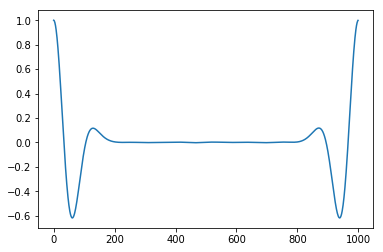

In [74]:
# plt.plot(ixx)
plt.plot(ixy / (x.size * stdx * stdy))

In [189]:
ixy.real / ixy.size

array([ 0.00049218,  0.00049163,  0.00048989, ...,  0.00048661,
        0.00048966,  0.00049152])

In [148]:
ixx.real[0]

0.586322878010479

In [170]:
np.correlate(a.x, a.x)

array([ 0.58632288])

In [169]:
np.var(a.x)*(a.x.size)

0.58632152133470516

In [1]:
np.abs(ixx)

NameError: name 'np' is not defined

In [16]:
welch?

In [24]:
np.fft.ifft?

In [23]:
%timeit np.fft.fft(x)

37.1 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
%timeit np.fft.rfft(x)

26.3 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
t1 = np.fft.fft(x)
t2 = np.fft.rfft(x)
t1 - t2

ValueError: operands could not be broadcast together with shapes (1000,) (501,) 

In [33]:
x.shape

(1000,)

In [37]:
ixy

array([  4.93874456e-01,   4.93251478e-01,   4.91425547e-01,
         4.88402828e-01,   4.84193563e-01,   4.78812030e-01,
         4.72276480e-01,   4.64609057e-01,   4.55835703e-01,
         4.45986043e-01,   4.35093262e-01,   4.23193954e-01,
         4.10327971e-01,   3.96538247e-01,   3.81870616e-01,
         3.66373618e-01,   3.50098288e-01,   3.33097946e-01,
         3.15427967e-01,   2.97145553e-01,   2.78309495e-01,
         2.58979930e-01,   2.39218094e-01,   2.19086073e-01,
         1.98646555e-01,   1.77962579e-01,   1.57097286e-01,
         1.36113672e-01,   1.15074348e-01,   9.40413001e-02,
         7.30756558e-02,   5.22374618e-02,   3.15854646e-02,
         1.11769022e-02,  -8.93269481e-03,  -2.86896920e-02,
        -4.80425282e-02,  -6.69418812e-02,  -8.53408201e-02,
        -1.03194945e-01,  -1.20462515e-01,  -1.37104558e-01,
        -1.53084970e-01,  -1.68370598e-01,  -1.82931313e-01,
        -1.96740059e-01,  -2.09772900e-01,  -2.22009037e-01,
        -2.33430829e-01,

In [75]:
rotate = sw.core.core.rotate

def gridcov(x, y, w0, w1, degs, slags):
    # prepare empty covariance arrays
    g = np.empty((degs.size, slags.size, 2, 2))
    n = w1 - w0
    npsum = np.sum # remove dots from inner loop
    # now loop and calculate
    for ii in range(degs.size):
        # prepare a list of data rotated to degs
        rot = rotate(x, y, degs[ii])
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        # loop over lags
        for jj in range(slags.size):
            slag = slags[jj]
            wx, wy  = slagchop(rot[0], rot[1], w0, w1, -slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            g[ii, jj, 0, 0] = npsum(dx * dx)
            g[ii, jj, 1, 0] = g[ii, jj, 0, 1] = npsum(dx * dy)
            g[ii, jj, 1, 1] = npsum(dy * dy)
    return g / n
    

In [84]:
rotate = sw.core.core.rotate

def gridcovfreq(x, y):
    # Fourier Transform
    x = x - np.mean(x)
    y = y - np.mean(y)
    fx = np.fft.rfft(x)
    fy = np.fft.rfft(y)
    n = x.size
    covs = []
    # now loop and calculate
    for ii in range(90):
        # prepare a list of data rotated to degs
        rot = rotate(fx, fy, ii)
        fxr = rot[0]
        fxrc = fxr.conj()
        fyr = rot[1]
        fyrc = fyr.conj()
        # correlate
        cxx = fxr * fxrc
        cyy = fyr * fyrc
        cxy = fxr * fyrc
        # inverse transform
        icxx = np.fft.irfft(cxx) / n
        icyy = np.fft.irfft(cyy) / n
        icxy = np.fft.irfft(cxy) / n
        # get info
        varx = icxx[0]
        vary = icyy[0]
        rho = icxy / math.sqrt(varx*vary)
        covs.append(rho)
    return np.array(covs)

In [86]:
cov.shape

(90, 1000)

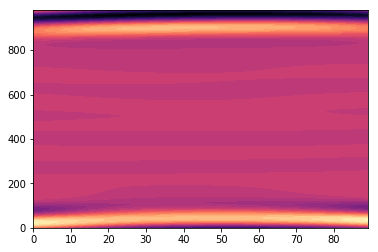

In [94]:
a = sw.SplitWave(pol=0, split=(30,2))
x = a.x
y = a.y
cov = gridcovfreq(x,y)
xx,yy = np.meshgrid(np.arange(90), np.arange(a.x.size-1))
plt.contourf(xx,yy,cov.T,30,cmap='magma')
plt.show()

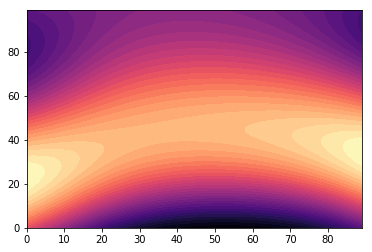

In [96]:
xx,yy = np.meshgrid(np.arange(90), np.arange(100))
plt.contourf(xx,yy,cov[:,0:100].T,30,cmap='magma')
plt.show()

In [98]:
a._delta * 20

2.0